In [78]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Exercise 1

In [36]:
def simulate_sir_simple(lam, mu, I_0, T):
    # initialize arrays for S, I, R
    S = np.zeros(T+1)
    I = np.zeros(T+1)
    R = np.zeros(T+1)
    # define odes for S, I, R
    def dS(S, I):
        return -lam*S*I
    def dI(S, I):
        return lam*S*I - mu*I
    def dR(I):
        return mu*I
    
    # initial conditions
    S[0] = 1 - I_0
    I[0] = I_0

    # simulate the ODEs
    for t in range(T):
        S[t+1] = S[t] + dS(S[t], I[t])
        I[t+1] = I[t] + dI(S[t], I[t])
        R[t+1] = R[t] + dR(I[t])

    # calculate the daily changes
    delta_S = np.zeros(T)
    delta_R = np.zeros(T)
    for t in range(1, T):
        delta_S[t] = S[t-1] - S[t]
        delta_R[t] = R[t-1] - R[t]

    X = np.array([(delta_S[i], delta_R[i]) for i in range(T)])
    C = np.array([(S[i], I[i], R[i]) for i in range(T)])
    return X

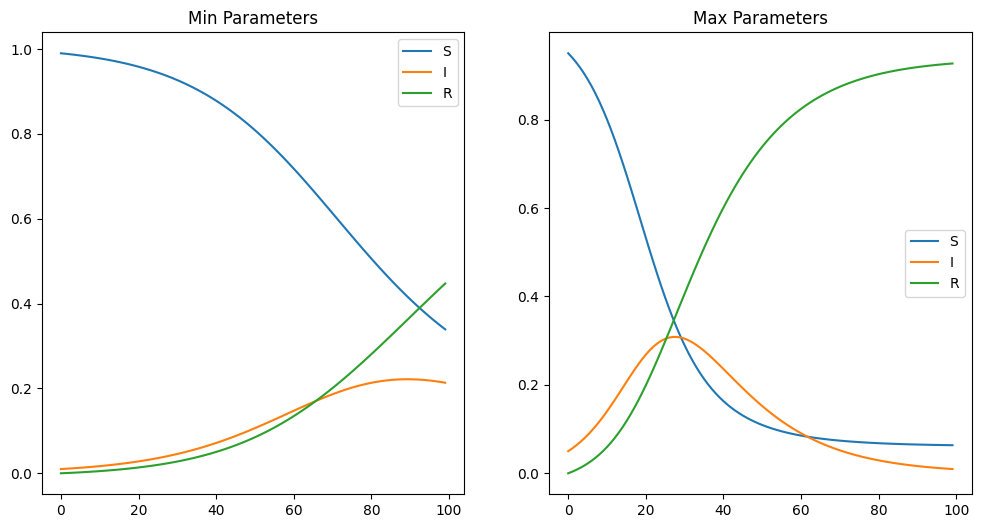

In [34]:
# plot the min and max parameters to see, for the later prior definition  (the C is removed from the function output, add to test new parameters)
def plot_sir(lam_min, lam_max, mu_min, mu_max, I0_min, I0_max, T=100):
    # simulate min parameters 
    _ , C_min = simulate_sir_simple(lam_min, mu_min, I0_min, T)

    # simulate max parameters
    _ , C_max = simulate_sir_simple(lam_max, mu_max, I0_max, T)

    # plot 
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(C_min[:, 0], label='S')
    ax[0].plot(C_min[:, 1], label='I')
    ax[0].plot(C_min[:, 2], label='R')
    ax[0].set_title('Min Parameters')
    ax[0].legend()
    ax[1].plot(C_max[:, 0], label='S')
    ax[1].plot(C_max[:, 1], label='I')
    ax[1].plot(C_max[:, 2], label='R')
    ax[1].set_title('Max Parameters')
    ax[1].legend()
    plt.show()

plot_sir(lam_min=0.095, lam_max=0.2, mu_min=0.04, mu_max=0.07, I0_min=0.01, I0_max=0.05)


I tried to shift the 'peak' of the Infektions to the end with the minimal parameters and to the beginning with the max parameters 

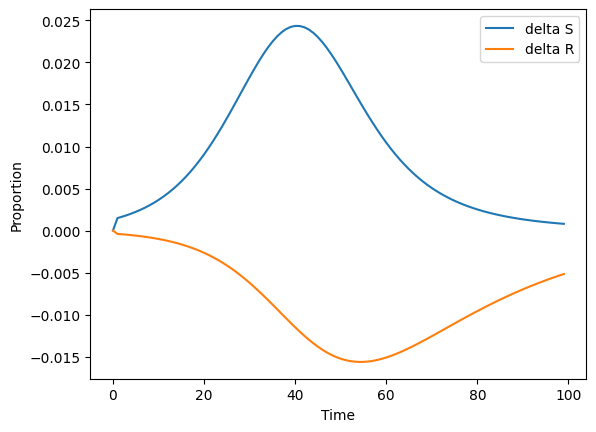

In [38]:
# parameters 
# Removed C from the function output from now on
lam = 0.15
mu = 0.04
I_0 = 0.01
T = 100

# simulate
X = simulate_sir_simple(lam, mu, I_0, T)

plt.plot(X[:, 0], label='delta S')
plt.plot(X[:, 1], label='delta R')
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.legend()
plt.show()

In [83]:
# define the prior distribution for the simulation parameters
def prior_distribution():
    lam = random.uniform(0.095, 0.2)
    #lam = np.random.uniform(0.1, 0.2, 1)
    mu = random.uniform(0.04, 0.07)
    #mu = np.random.uniform(0.01, 0.05, 1)
    I_0 = random.uniform(0.01, 0.05)
    #I_0 = np.random.uniform(0.005, 0.02, 1)
    return np.array([lam, mu, I_0])

In [84]:
# define a feed forward neural network
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(FeedForward, self).__init__()
        layers = []
        layer_size = input_size
        for i in range(num_layers):
            layers.append(nn.Linear(layer_size, hidden_size))
            layers.append(nn.ReLU())
            layer_size = hidden_size
        layers.append(nn.Linear(layer_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [100]:
def train_feedforward(model, simulation, priors, epochs, lr, days):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        sample = priors()
        # create tensor
        X = torch.tensor(simulation(*sample, days), dtype=torch.float32)
        # duplicate samples 
        samples = [sample for _ in range(days)]
        samples = torch.tensor(samples, dtype=torch.float32).to(device)
        # pass through model
        output = model(X)
        # calculate loss
        loss = criterion(output, samples)
        # training
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        #print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    return losses


In [ ]:
# test run of the simulation 
model = FeedForward(2, 64, 2, 3).to(device)

train_feedforward(model, simulate_sir_simple, prior_distribution, epochs=50, lr=0.001, days=100)

In [93]:
# define function to evaluate the model 
def mse_evaluation(model, X, parameters, days):
    duplicates = [parameters for _ in range(days)]
    duplicates = torch.tensor(duplicates, dtype=torch.float32).to(device)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    output = model(X)

    MSE = nn.MSELoss()(output, duplicates).item()

    return MSE


In [94]:
# test the evaluation function
lam = 0.15
mu = 0.04
I_0 = 0.01
parameters = np.array([lam, mu, I_0])
X_test = simulate_sir_simple(*parameters, 100) 

# evaluate the model
mse_evaluation(model, X_test, parameters, 100)


0.0003005092148669064

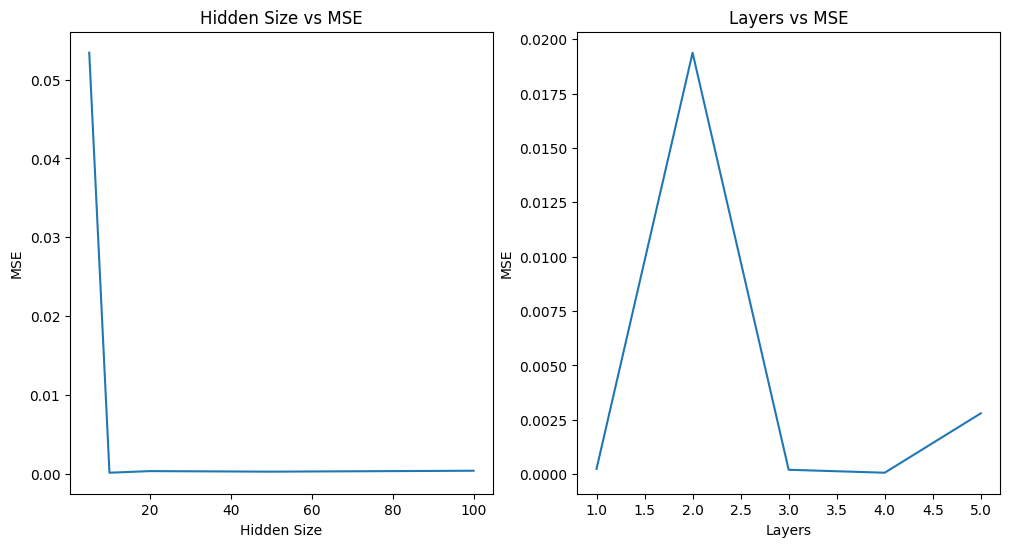

In [101]:
# define model test set 
lam = 0.15
mu = 0.04
I_0 = 0.01
parameters = np.array([lam, mu, I_0])
X_test = simulate_sir_simple(*parameters, 100) 

# define hyperparameters 
hidden_sizes = [5, 10, 20, 50, 100]
layers = [1, 2, 3, 4, 5]
default_layers = 2
default_hidden_size = 10
lr = 0.001
epochs = 100
days = 100


# plot different model hyperparameters for the feed forward model

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
hidden_size_mse = []
layer_mse = []
for hidden_size in hidden_sizes:
    model = FeedForward(2, hidden_size, default_layers, 3).to(device)
    losses = train_feedforward(model, simulate_sir_simple, prior_distribution, epochs, lr, days)
    hidden_size_mse.append(mse_evaluation(model, X_test, parameters, days))

for layer in layers:
    model = FeedForward(2, default_hidden_size, layer, 3).to(device)
    losses = train_feedforward(model, simulate_sir_simple, prior_distribution, epochs, lr, days)
    layer_mse.append(mse_evaluation(model, X_test, parameters, days))


ax[0].plot(hidden_sizes, hidden_size_mse)
ax[0].set_xlabel('Hidden Size')
ax[0].set_ylabel('MSE')
ax[0].set_title('Hidden Size vs MSE')
ax[1].plot(layers, layer_mse)
ax[1].set_xlabel('Layers')
ax[1].set_ylabel('MSE')
ax[1].set_title('Layers vs MSE')
plt.show()


